In [1]:
import numpy as np
import pandas as pd
import polars as pl
import requests
import streamlit as st
from ensmallen import HyperSketchingPy
from grape import Graph
from src.models import LightGBM

/home/visanim/.cache/pypoetry/virtualenvs/lotus-hypersketching-ruHkzsWs-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
URL_CLASSYFIRE = "https://structure.gnps2.org/classyfire?smiles="
URL_NP_CLASSIFIER = "https://npclassifier.gnps2.org/classify?smiles="

In [3]:
def classify_with_np_classifier(compound: str) -> int:
    """Submit a compound information to the NP Classifier service for evaluation
    and receive the classification of the compound.

    :param compound: The SMILES of the compound of interest
    :type compound: str
    :return: A dictionary with the results of the classification
    :rtype: dict

    >>> classify_with_np_classifier('CCC')

    """
    r = requests.get(
        URL_NP_CLASSIFIER + compound,
    )
    r.raise_for_status()
    return r.json()

In [4]:
model = LightGBM.load_model("lightgbm_model.pkl")
graph = Graph.from_csv(
    name="lotus_with_wikidata",
    node_path="./data/full_wd_taxonomy_with_molecules_in_lotus_clean_nodes.csv",
    edge_path="./data/full_wd_taxonomy_with_molecules_in_lotus_clean_edges.csv",
    node_list_separator="\t",
    node_list_header=True,
    nodes_column_number=0,
    node_list_node_types_column_number=1,
    edge_list_separator="\t",
    edge_list_header=True,
    sources_column_number=0,
    destinations_column_number=1,
    edge_list_edge_types_column_number=2,
    directed=False,
    load_edge_list_in_parallel=False,
    load_node_list_in_parallel=False,
)

species_phylo = pd.read_csv("./data/species/full_wikidata_taxonomy_nodes.csv")

lotus = pl.read_csv(
    "data/molecules/230106_frozen_metadata.csv.gz",
    dtypes={
        "structure_xlogp": pl.Float32,
        "structure_cid": pl.UInt32,
        "organism_taxonomy_ncbiid": pl.UInt32,
        "organism_taxonomy_ottid": pl.UInt32,
        "structure_stereocenters_total": pl.UInt32,
        "structure_stereocenters_unspecified": pl.UInt32,
    },
    infer_schema_length=50000,
    null_values=["", "NA"],
)

lotus = lotus.with_columns(
    pl.col("organism_taxonomy_gbifid")
    .map_elements(lambda x: np.nan if x.startswith("c(") else x)
    .cast(pl.UInt32)
    .alias("organism_taxonomy_gbifid")
)
lotus = lotus.with_columns(
    ("wd:" + pl.col("organism_wikidata").str.extract(r"(Q\d+)")).alias("wd_species")
)

lotus = lotus.with_columns(
    ("wd:" + pl.col("structure_wikidata").str.extract(r"(Q\d+)")).alias("wd_molecule")
)

In [5]:
compound = "CC(C)CCC(C)C(=O)NCCCNC(=N)N"
dct = classify_with_np_classifier(compound)
_ = dct.pop("isglycoside")

# We first create the edges dataframe
edges_np_classifier = (
    pd.concat(
        [
            pd.DataFrame([compound]),
            pd.DataFrame.from_dict(dct, orient="index"),
        ]
    )
    .dropna()
    .reset_index(drop=True)
)

edges_np_classifier[1] = edges_np_classifier.iloc[:, 0].shift(-1)
edges_np_classifier.dropna(inplace=True)
edges_np_classifier.rename(columns={0: "child", 1: "parent"}, inplace=True)
edges_np_classifier["type"] = "biolink:subclass_of"

# then the nodes dataframe
nodes_np_classifier = (
    pd.DataFrame(
        {
            "node": pd.concat([edges_np_classifier.child, edges_np_classifier.parent]),
            "type": "biolink:ChemicalEntity",
        }
    )
    .drop_duplicates()
    .reset_index(drop=True)
)

In [6]:
graph_np_classifier = Graph.from_pd(
    directed=False,
    edges_df=edges_np_classifier,
    nodes_df=nodes_np_classifier,
    node_name_column="node",
    node_type_column="type",
    edge_src_column="child",
    edge_dst_column="parent",
    edge_type_column="type",
)

In [7]:
graph_merged = graph | graph_np_classifier

In [8]:
lotus_filtered = lotus.select(
    [
        "wd_species",
        "organism_wikidata",
        "organism_name",
        "organism_taxonomy_01domain",
        "organism_taxonomy_02kingdom",
        "organism_taxonomy_03phylum",
        "organism_taxonomy_04class",
        "organism_taxonomy_05order",
        "organism_taxonomy_06family",
        "organism_taxonomy_08genus",
        "organism_taxonomy_09species",
        "organism_taxonomy_gbifid",
        "organism_taxonomy_ncbiid",
        "organism_taxonomy_ottid",
    ]
)

lotus_filtered = lotus_filtered.unique().to_pandas()
lotus_filtered = lotus_filtered.sample(3000)
lotus_filtered["molecule"] = compound
species_to_remove = list(set(lotus_filtered.wd_species) - set(species_phylo.node))
lotus_filtered = lotus_filtered[~lotus_filtered.wd_species.isin(species_to_remove)]
molecules_id = graph_merged.get_node_ids_from_node_names(lotus_filtered.molecule)
species_id = graph_merged.get_node_ids_from_node_names(lotus_filtered.wd_species)

In [9]:
sketching_features = HyperSketchingPy(
    hops=2,
    normalize=False,
    graph=graph_merged,
)
sketching_features.fit()

In [11]:
lotus_filtered = lotus.select(
    [
        "wd_species",
        "wd_molecule",
    ]
)
lotus_filtered = lotus_filtered.unique().to_pandas()

In [12]:
lotus_filtered = lotus_filtered.sample(3000)
species_to_remove = list(set(lotus_filtered.wd_species) - set(species_phylo.node))
lotus_filtered = lotus_filtered[~lotus_filtered.wd_species.isin(species_to_remove)]
molecules_id = graph_merged.get_node_ids_from_node_names(lotus_filtered.wd_molecule)
species_id = graph_merged.get_node_ids_from_node_names(lotus_filtered.wd_species)

In [13]:
# create the sketching features
pair_sketching_positive = sketching_features.unknown(
    sources=molecules_id.astype("uint32"),
    destinations=species_id.astype("uint32"),
    feature_combination="addition",
)

In [14]:
pos = graph_merged.filter_from_names(
    edge_type_names_to_keep=["biolink:in_taxon"],
)
neg = pos.sample_negative_graph(
    number_of_negative_samples=3000,
    sample_edge_types=False,
    only_from_same_component=False,
    use_scale_free_distribution=True,
    random_state=23391 * (3 + 1),
)

neg_sources = neg.get_directed_source_node_ids()
neg_destinations = neg.get_directed_destination_node_ids()
sk_negative_features = sketching_features.unknown(
    sources=neg_sources,
    destinations=neg_destinations,
    feature_combination="addition",
)

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    verbose=2,
)
X = np.concatenate(
    [
        pair_sketching_unknown,
        sk_negative_features,
        pair_sketching_positive,
    ]
)
X_embedded = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8996 samples in 0.006s...
[t-SNE] Computed neighbors for 8996 samples in 0.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8996
[t-SNE] Computed conditional probabilities for sample 2000 / 8996
[t-SNE] Computed conditional probabilities for sample 3000 / 8996
[t-SNE] Computed conditional probabilities for sample 4000 / 8996
[t-SNE] Computed conditional probabilities for sample 5000 / 8996
[t-SNE] Computed conditional probabilities for sample 6000 / 8996
[t-SNE] Computed conditional probabilities for sample 7000 / 8996
[t-SNE] Computed conditional probabilities for sample 8000 / 8996
[t-SNE] Computed conditional probabilities for sample 8996 / 8996
[t-SNE] Mean sigma: 19.715499
[t-SNE] Computed conditional probabilities in 0.275s
[t-SNE] Iteration 50: error = 79.8216019, gradient norm = 0.0170453 (50 iterations in 0.663s)
[t-SNE] Iteration 100: error = 71.0181427, gradient norm = 0.0104989 (50 iterations in 0

<Axes: xlabel='x', ylabel='y'>

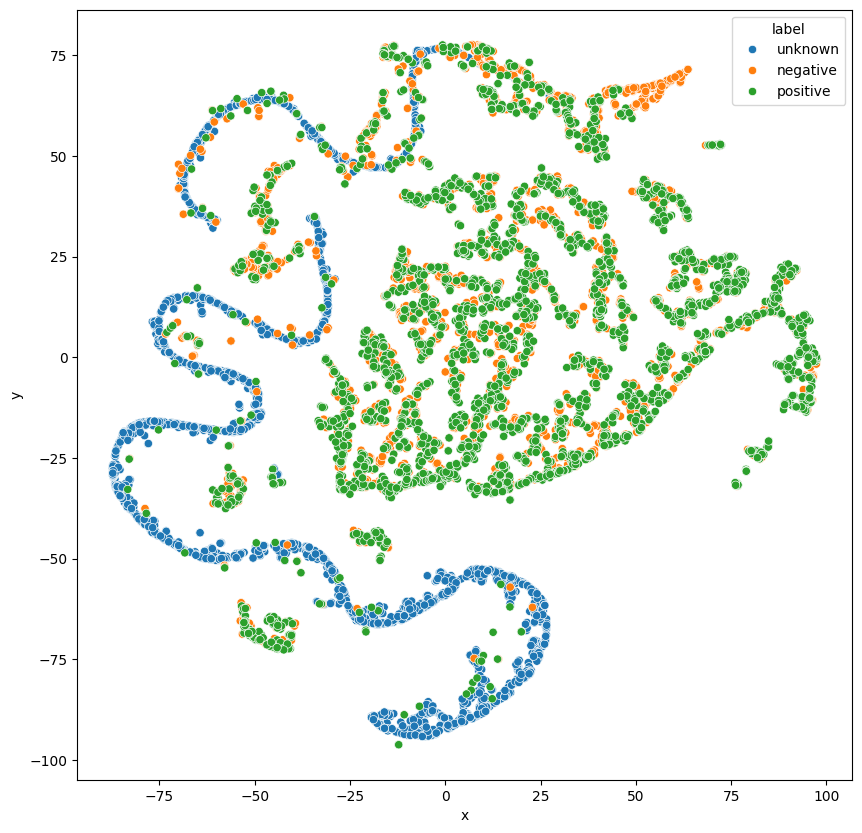

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(X_embedded, columns=["x", "y"])
df["label"] = (
    ["unknown"] * pair_sketching_unknown.shape[0]
    + ["negative"] * sk_negative_features.shape[0]
    + ["positive"] * pair_sketching_positive.shape[0]
)

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x="x", y="y", hue="label", ax=ax)

(array([  14.,   15.,   13.,   18.,   15.,   26.,    7.,   18.,   21.,
          15.,   18.,    9.,   17.,   21.,   14.,   17.,   18.,   15.,
          13.,   15.,   15.,   18.,   20.,   17.,   14.,   20.,   26.,
          23.,   20.,   26.,   20.,   25.,   17.,   32.,   27.,   30.,
          32.,   34.,   35.,   29.,   35.,   41.,   45.,   67.,   63.,
          88.,  122.,  186.,  429., 1122.]),
 array([0.01394767, 0.03366143, 0.05337518, 0.07308894, 0.0928027 ,
        0.11251646, 0.13223021, 0.15194397, 0.17165773, 0.19137148,
        0.21108524, 0.230799  , 0.25051275, 0.27022651, 0.28994027,
        0.30965403, 0.32936778, 0.34908154, 0.3687953 , 0.38850905,
        0.40822281, 0.42793657, 0.44765032, 0.46736408, 0.48707784,
        0.5067916 , 0.52650535, 0.54621911, 0.56593287, 0.58564662,
        0.60536038, 0.62507414, 0.6447879 , 0.66450165, 0.68421541,
        0.70392917, 0.72364292, 0.74335668, 0.76307044, 0.78278419,
        0.80249795, 0.82221171, 0.84192547, 0.86163922, 

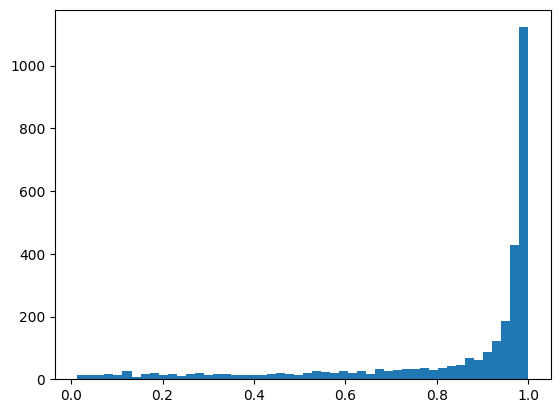

In [17]:
plt.hist(
    model.predict_proba(pair_sketching_positive)[:, 1],
    bins=50,
)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   39.,
         222.,  836., 1143.,  535.,  224.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

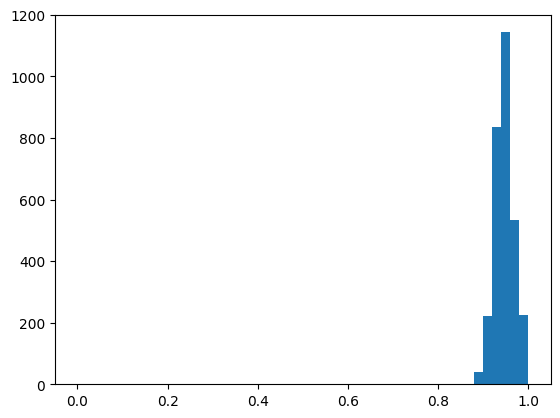

In [18]:
plt.hist(
    model.predict_proba(pair_sketching_unknown)[:, 1],
    bins=50,
    range=(0, 1),
)

(array([733., 905., 272., 157., 126., 102.,  93.,  52.,  48.,  43.,  28.,
         39.,  28.,  41.,  36.,  30.,  27.,  18.,  11.,  14.,  18.,  15.,
         11.,   9.,   8.,   8.,   8.,   9.,   9.,   6.,   8.,   6.,   8.,
          3.,   7.,   8.,   5.,   2.,   4.,   6.,   7.,   3.,   4.,   7.,
          6.,   4.,   7.,   1.,   0.,   0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

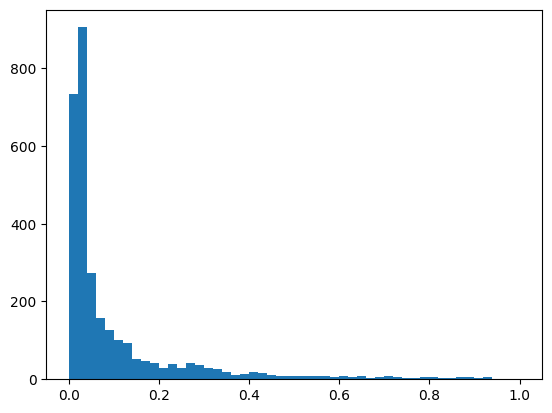

In [19]:
plt.hist(
    model.predict_proba(sk_negative_features)[:, 1],
    bins=50,
    range=(0, 1),
)

### Let's try to add an edge from the compound "CC(C)CCC(C)C(=O)NCCCNC(=N)N" to a species.

In [20]:
edges_np_classifier_new = pd.concat(
    [
        edges_np_classifier,
        pd.DataFrame(
            {
                "child": ["CC(C)CCC(C)C(=O)NCCCNC(=N)N"],
                "parent": ["wd:Q25834677"],
                "type": ["biolink:in_taxon"],
            }
        ),
    ]
)

In [21]:
nodes_np_classifier_new = (
    pd.DataFrame(
        {
            "node": pd.concat(
                [edges_np_classifier_new.child, edges_np_classifier_new.parent]
            ),
            "type": "biolink:ChemicalEntity",
        }
    )
    .drop_duplicates()
    .reset_index(drop=True)
)
nodes_np_classifier_new.iloc[4, 1] = "biolink:OrganismTaxon"

In [22]:
graph_np_classifier_new = Graph.from_pd(
    directed=False,
    edges_df=edges_np_classifier_new,
    nodes_df=nodes_np_classifier_new,
    node_name_column="node",
    node_type_column="type",
    edge_src_column="child",
    edge_dst_column="parent",
    edge_type_column="type",
)

In [23]:
graph_merged_new = graph | graph_np_classifier_new

In [24]:
lotus_filtered = lotus.select(
    [
        "wd_species",
        "organism_wikidata",
        "organism_name",
        "organism_taxonomy_01domain",
        "organism_taxonomy_02kingdom",
        "organism_taxonomy_03phylum",
        "organism_taxonomy_04class",
        "organism_taxonomy_05order",
        "organism_taxonomy_06family",
        "organism_taxonomy_08genus",
        "organism_taxonomy_09species",
        "organism_taxonomy_gbifid",
        "organism_taxonomy_ncbiid",
        "organism_taxonomy_ottid",
    ]
)

lotus_filtered = lotus_filtered.unique().to_pandas()
lotus_filtered = lotus_filtered.sample(3000)
lotus_filtered["molecule"] = compound
species_to_remove = list(set(lotus_filtered.wd_species) - set(species_phylo.node))
lotus_filtered = lotus_filtered[~lotus_filtered.wd_species.isin(species_to_remove)]
molecules_id = graph_merged.get_node_ids_from_node_names(lotus_filtered.molecule)
species_id = graph_merged.get_node_ids_from_node_names(lotus_filtered.wd_species)

In [ ]:
sketching_features = HyperSketchingPy(
    hops=2,
    normalize=False,
    graph=graph_merged_new,
)
sketching_features.fit()

In [ ]:
# create the sketching features
pair_sketching_unknown = sketching_features.unknown(
    sources=molecules_id.astype("uint32"),
    destinations=species_id.astype("uint32"),
    feature_combination="addition",
)

(array([  9.,  37.,  69., 120., 176., 131., 162., 114., 118., 124., 236.,
        163., 240., 204., 115., 161., 108.,  59.,  59.,  65.,  48.,  48.,
        101., 131.,  23.,  38.,  16.,  39.,  13.,   3.,  11.,   0.,   1.,
          2.,   2.,   4.,   7.,  11.,   4.,   1.,   0.,   0.,   0.,  12.,
          0.,   0.,   2.,   0.,   2.,   3.]),
 array([0.13176773, 0.14884604, 0.16592434, 0.18300265, 0.20008095,
        0.21715926, 0.23423756, 0.25131587, 0.26839418, 0.28547248,
        0.30255079, 0.31962909, 0.3367074 , 0.3537857 , 0.37086401,
        0.38794232, 0.40502062, 0.42209893, 0.43917723, 0.45625554,
        0.47333385, 0.49041215, 0.50749046, 0.52456876, 0.54164707,
        0.55872537, 0.57580368, 0.59288199, 0.60996029, 0.6270386 ,
        0.6441169 , 0.66119521, 0.67827351, 0.69535182, 0.71243013,
        0.72950843, 0.74658674, 0.76366504, 0.78074335, 0.79782165,
        0.81489996, 0.83197827, 0.84905657, 0.86613488, 0.88321318,
        0.90029149, 0.9173698 , 0.9344481 , 0.

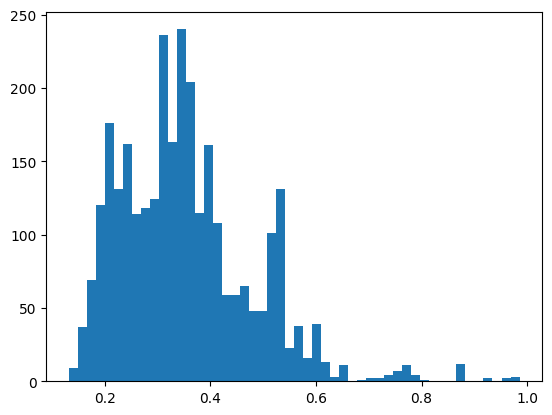

In [27]:
plt.hist(
    model.predict_proba(pair_sketching_unknown)[:, 1],
    bins=50,
)